In [1]:
%load_ext IPython.extensions.autoreload
%autoreload 2
%matplotlib ipympl
import matplotlib
# matplotlib.use('TKAgg')

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


In [2]:
from matplotlib import pyplot as plt

from qdc.diffuser.diffuser_result import DiffuserResult
from qdc.diffuser.diffuser_sim import DiffuserSimulation
import numpy as np 

show_all = False

sim = DiffuserSimulation(
    Nx=2048, Ny=2048,
    Lx=8e-3, Ly=8e-3,
    wl0=808e-9,
    Dwl=300e-9,
    N_wl=21,
    waist=40e-6,
    focal_length=200e-3,
    init_off_axis=0.,
    # diffuser_angle=0.0001,  # for wrapped 
    # rms_height=7,   # for wrapped 
    diffuser_angle=0.015 * 2*np.pi/360,
    rms_height=15, 
    diffuser_type='ohad',  # "ohad", "rfft", "wrapped", 
    # pinholes=[0.5, 0.5, 0.5], # units of focal length, relative distances 
    pinholes=[], # units of focal length, relative distances 
    pinhole_D=4e-3
)

res = sim.run_SPDC_simulation()
res = sim.run_classical_simulation()

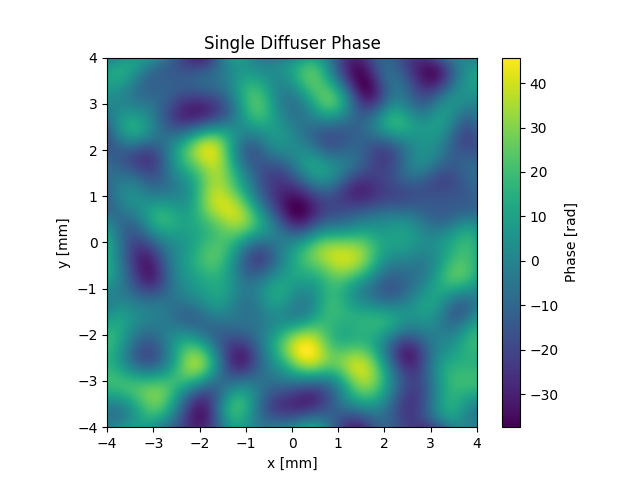

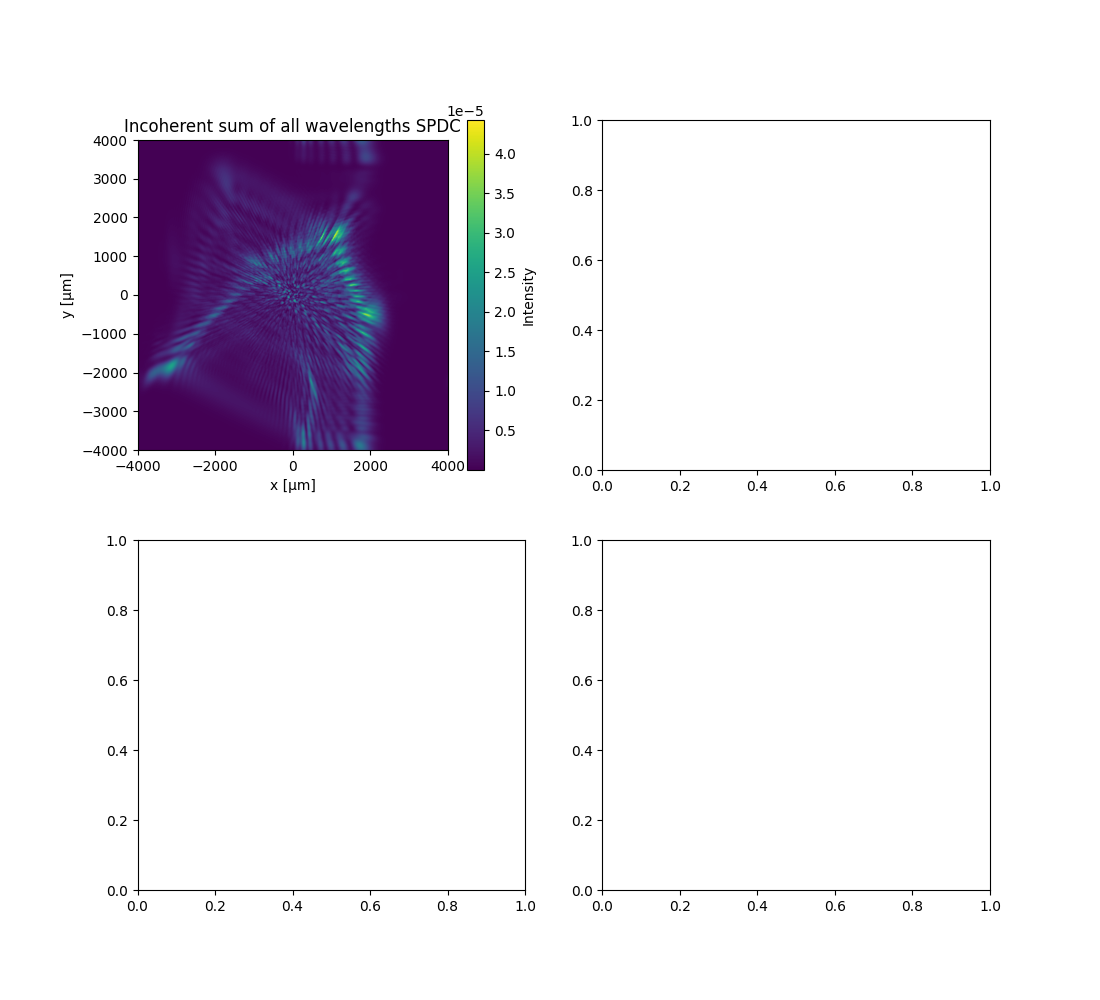

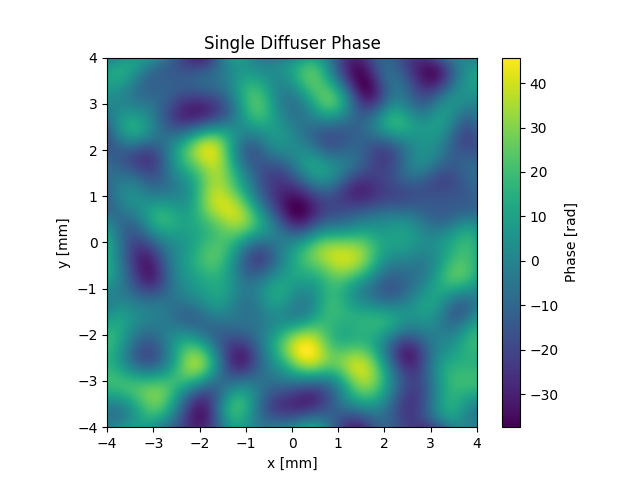

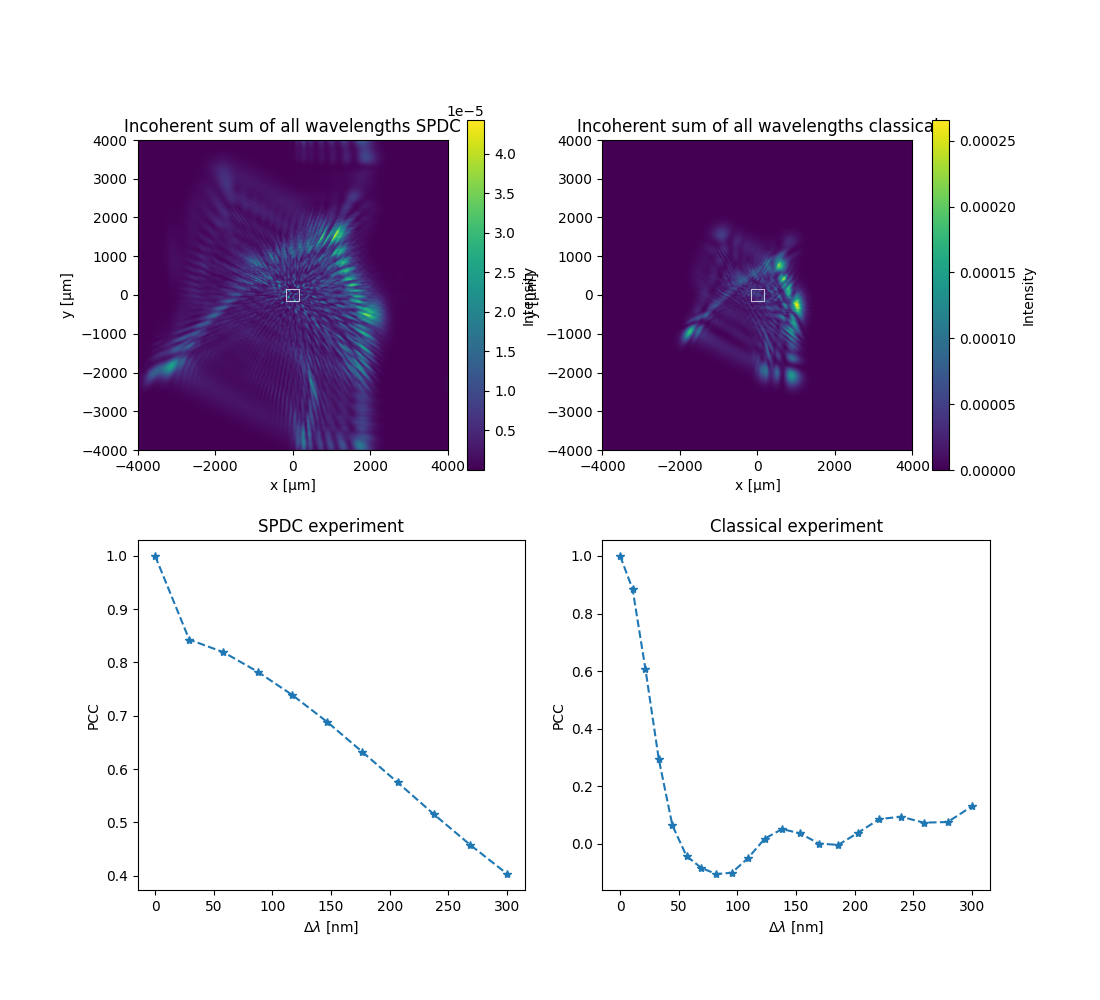

In [3]:
res.show_diffuser()
mid = res.Nx // 2 
D = 40
res._populate_res_SPDC(roi=np.index_exp[mid-D:mid+D, mid-D:mid+D])
res._populate_res_classical(roi=np.index_exp[mid-D:mid+D, mid-D:mid+D])
res.show(sq_D=D*(res.x[1] - res.x[0]) * 1e6)

In [18]:
plt.close()

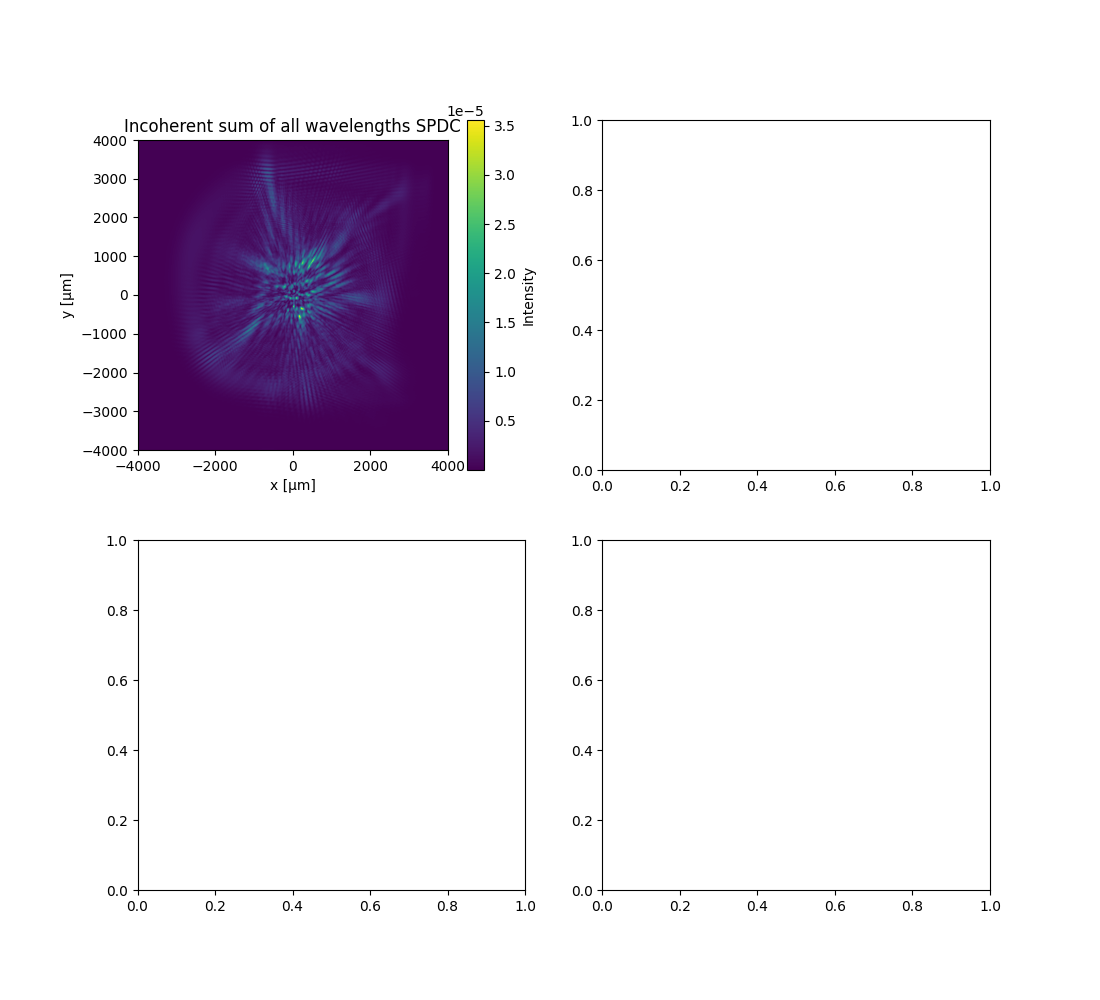

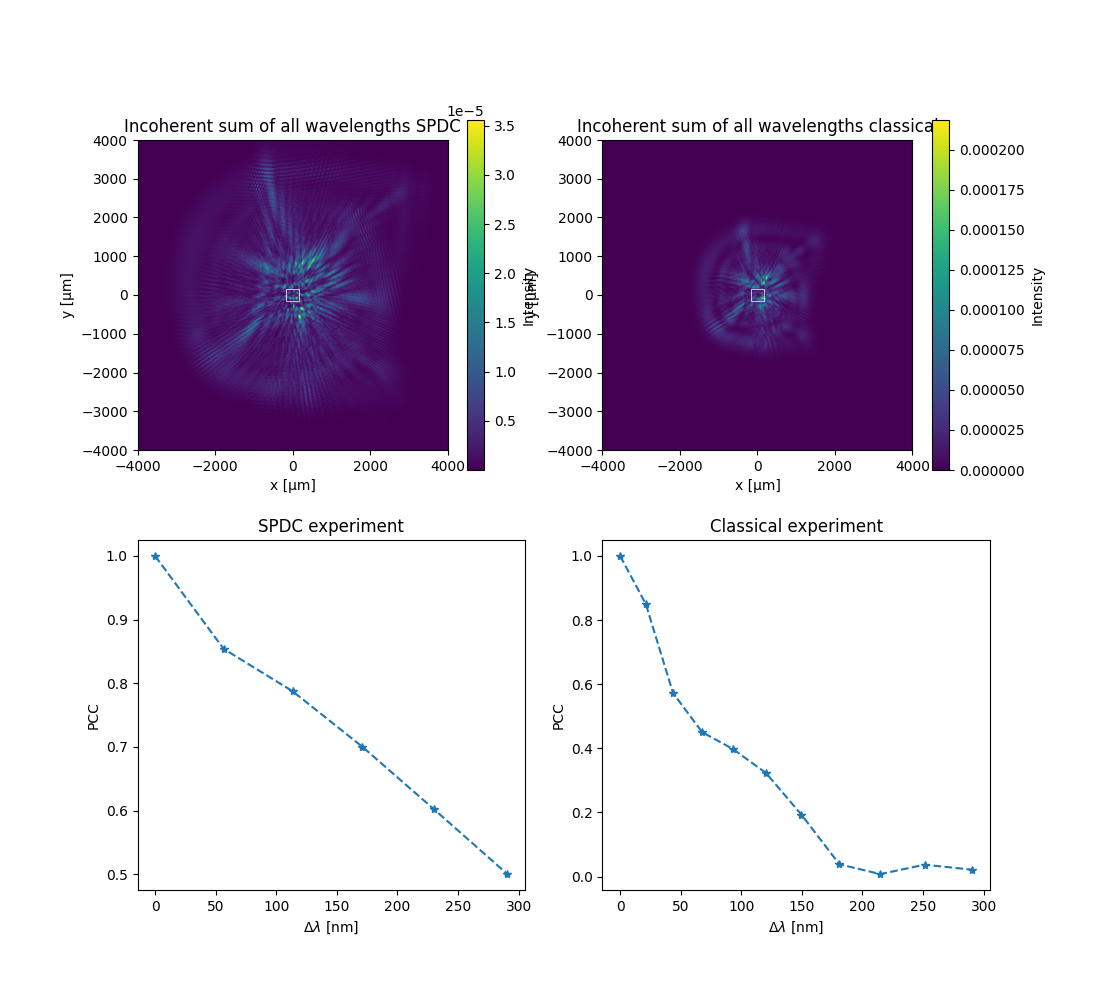

In [8]:
res.show(sq_D=D*(res.x[1] - res.x[0]) * 1e6)

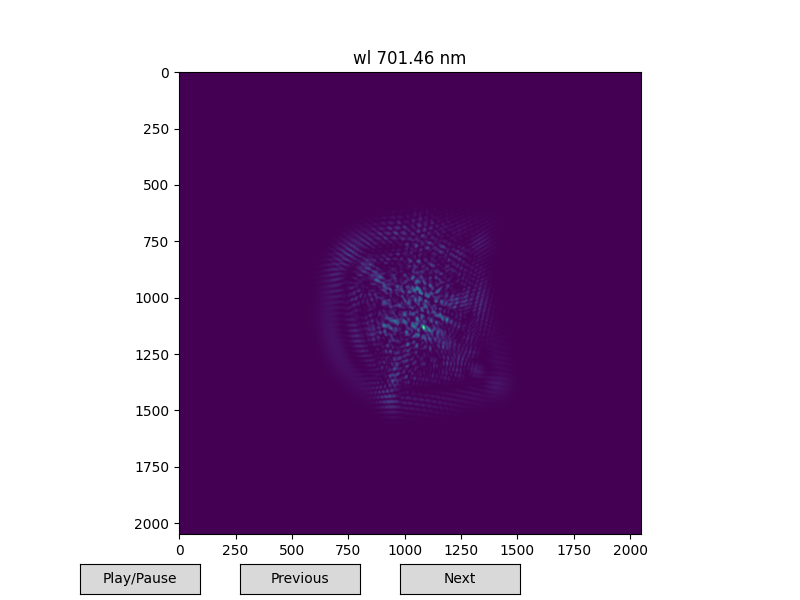

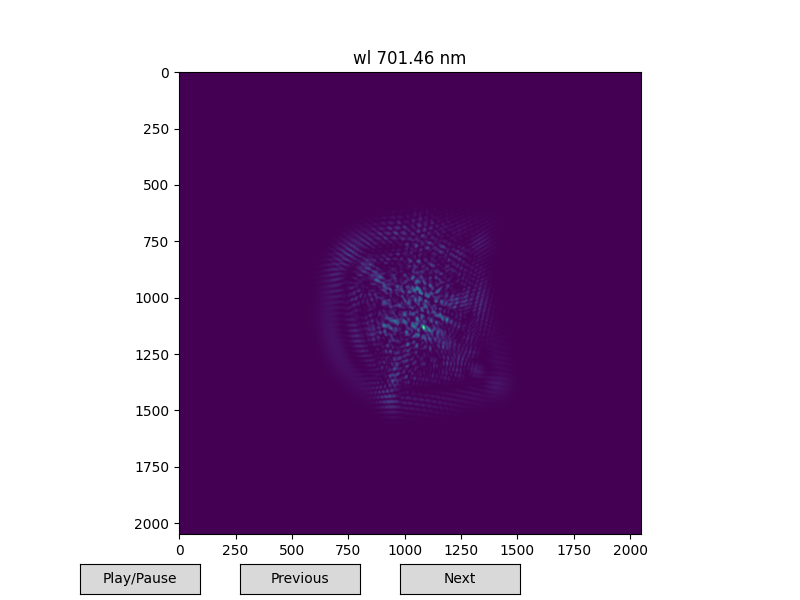

In [11]:
# res.show_interactive(SPDC=False) # , save_mp4_to="C:\\temp\\1.mp4")
# res.show_interactive(SPDC=False, save_mp4_to="C:\\temp\\6.mp4")
res.show_interactive(SPDC=False)

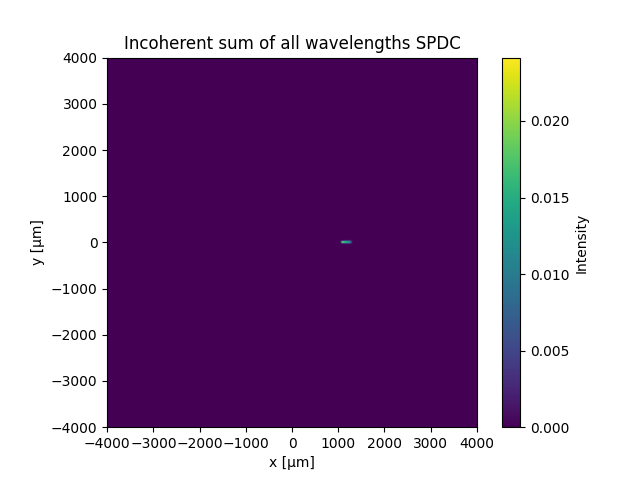

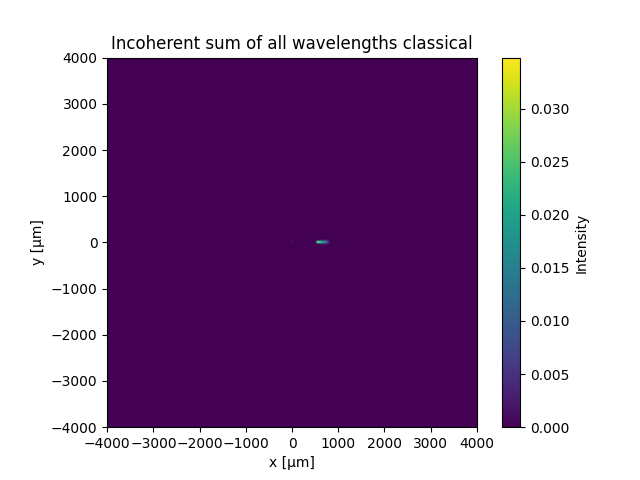

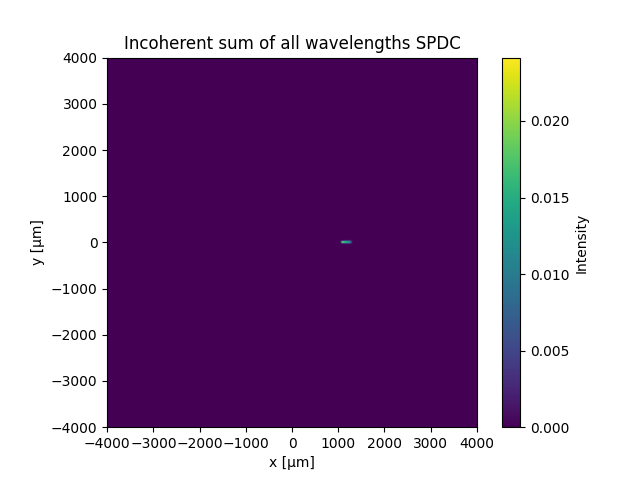

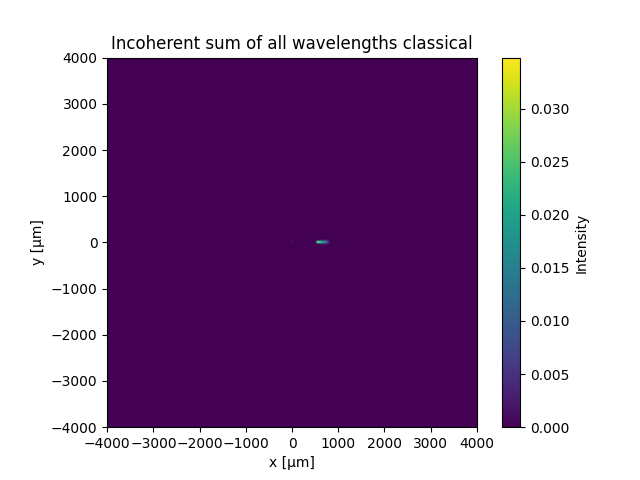

In [20]:
res.show_incoherent_sum_SPDC()
res.show_incoherent_sum_classical()

In [44]:
res.x[res.Nx//2 + 50] * 1e6

197.361993160723

In [17]:
sim.pinhole_D = 4e-3
im = np.angle(sim.get_lens_mask(f=200e-3, wl=808e-9))
im_pinhole = sim.get_pinhole_mask()
fig, ax = plt.subplots()
imm = ax.imshow(im * im_pinhole)
fig.colorbar(imm, ax=ax)
fig.show()

In [143]:
res.plot_SPDC_PCCs()
res.show_incoherent_sum_SPDC()

In [144]:
res.plot_SPDC_classical()
res.show_incoherent_sum_classical()

In [111]:
res.saveto("C:\\temp\\diff3_E.spdc")

In [73]:
sim.make_detection_gaussian(sim.wl0).show()

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: title={'center': 'Intensity (λ=808.0 nm)'}, xlabel='x [µm]', ylabel='y [µm]'>)

In [112]:
res2 = DiffuserResult()
res2.loadfrom(r"C:\temp\diff3_E.spdc.npz")

In [119]:
for var_name in res2.__dict__:
    arr = res2.__dict__[var_name]
    if arr is None:
        continue
    print(f"{var_name}: {arr.nbytes*1e-6} mega bytes in memory")

_SPDC_fields_wl: 8.8e-05 mega bytes in memory
SPDC_delta_lambdas: 8.8e-05 mega bytes in memory
wavelengths: 0.000168 mega bytes in memory
SPDC_PCCs: 8.8e-05 mega bytes in memory
SPDC_incoherent_sum: 16.777216 mega bytes in memory
Nx: 4e-06 mega bytes in memory
Ny: 4e-06 mega bytes in memory
x: 0.016384 mega bytes in memory
y: 0.016384 mega bytes in memory
wl0: 8e-06 mega bytes in memory
Dwl: 8e-06 mega bytes in memory
N_wl: 4e-06 mega bytes in memory
waist: 8e-06 mega bytes in memory
f: 8e-06 mega bytes in memory
init_off_axis: 8e-06 mega bytes in memory
diffuser_angle: 8e-06 mega bytes in memory
diffuser_mask: 33.554432 mega bytes in memory
achromat_lens: 1e-06 mega bytes in memory
